In [1]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
#Sampling Rate for Audio Playback
_SAMPLING_RATE = 16000

In [4]:
#Import Data
data_dir = pathlib.Path("data")
#data_dir = pathlib.Path("data/maestro-v2.0.0")
#if not data_dir.exists():
  #tf.keras.utils.get_file('maestro-v2.0.0-midi.zip', origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip', extract=True, cache_dir='.', cache_subdir='data')

In [5]:
filenames = glob.glob(str(data_dir/"*.mid"))
print("Number of Files:", len(filenames))

Number of Files: 553


In [6]:
sample_file = filenames[1]
print(sample_file)

data/13Mai, cher Mai.mid


In [7]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [8]:
#Display Audio
def display_audio(pm: pretty_midi.PrettyMIDI, seconds = 30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  #Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [9]:
#display_audio(pm)

In [10]:
print("Number of Instruments:", len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print("Instrument Name:", instrument_name)

Number of Instruments: 1
Instrument Name: Acoustic Grand Piano


In [11]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f"{i}: pitch={note.pitch}, note_name={note_name}," f"duration={duration:.4f}")

0: pitch=71, note_name=B4,duration=1.5000
1: pitch=73, note_name=C#5,duration=1.5000
2: pitch=71, note_name=B4,duration=1.5000
3: pitch=80, note_name=G#5,duration=1.5000
4: pitch=78, note_name=F#5,duration=1.5000
5: pitch=75, note_name=D#5,duration=1.5000
6: pitch=76, note_name=E5,duration=1.5000
7: pitch=71, note_name=B4,duration=1.5000
8: pitch=73, note_name=C#5,duration=1.5000
9: pitch=68, note_name=G#4,duration=1.5000


In [12]:
#Midi To Notes
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  #sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [13]:
#Notes by Pitch
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,71,0.0,1.5,0.0,1.5
1,73,1.5,3.0,1.5,1.5
2,71,3.0,4.5,1.5,1.5
3,80,4.5,6.0,1.5,1.5
4,78,6.0,7.5,1.5,1.5


In [14]:
#Notes by Note
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes["pitch"])
sample_note_names[:10]

array(['B4', 'C#5', 'B4', 'G#5', 'F#5', 'D#5', 'E5', 'B4', 'C#5', 'G#4'],
      dtype='<U3')

In [15]:
#Plotting
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [16]:
#plot_piano_roll(raw_notes, count=100)

In [17]:
#plot_piano_roll(raw_notes)

In [18]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

In [19]:
#plot_distributions(raw_notes)

In [20]:
#Create MIDI File
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str, velocity: int = 100) -> pretty_midi.PrettyMIDI:
  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))
  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']), start=start, end=end)
    instrument.notes.append(note)
    prev_start = start
  #Multiple Instruments Add Below To Loop?
  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [21]:
#example_file = 'example.midi'
#example_pm = notes_to_midi(raw_notes, out_file=example_file, instrument_name=instrument_name)
#display_audio(example_pm)

In [22]:
#Create Training Dataset
num_files = 10
all_notes = []
for f in filenames[150:175]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print("Number of Parsed Notes:", n_notes)

Number of Parsed Notes: 14583


In [23]:
#Create Dataset from Notes
key_order = ["pitch", "step", "duration"]
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [24]:
#Create Sequences so Net Will Train to Predict Next Note in Sequence
def create_sequences(dataset: tf.data.Dataset, seq_length: int, vocab_size = 128) -> tf.data.Dataset:
  #Returns TF Dataset of sequence and label examples
  seq_length = seq_length+1
  #Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  #Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x
  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}
    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [26]:
for seq, target in seq_ds.take(1):
  print("Sequence Shape:", seq.shape)
  print("Sequence Elements (First 10):", seq[0:10])
  print()
  print("Target:", target)

Sequence Shape: (25, 3)
Sequence Elements (First 10): tf.Tensor(
[[0.5        0.         0.5073524 ]
 [0.4296875  0.         0.58823467]
 [0.40625    0.00735293 0.51470533]
 [0.4609375  0.00367647 0.55882293]
 [0.3984375  0.53308767 0.15073513]
 [0.4921875  0.0220588  0.1213234 ]
 [0.40625    0.14705867 0.12499987]
 [0.5        0.00367647 0.0882352 ]
 [0.40625    0.3088232  0.53308767]
 [0.375      0.00367647 0.58088173]], shape=(10, 3), dtype=float64)

Target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=54.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.3272055333333337>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.07352933333333311>}


In [27]:
#Batch Examples and Configure Dataset for Performance
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds.shuffle(buffer_size).batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE))
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [28]:
#Create And Train Model

#Encourage Model to Output Positive Values
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 25, 256)      266240      ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 256)          525312      ['lstm[0][0]']                   
                                                                                                  
 duration (Dense)               (None, 1)            257         ['lstm_1[0][0]']                 
                                                                                              

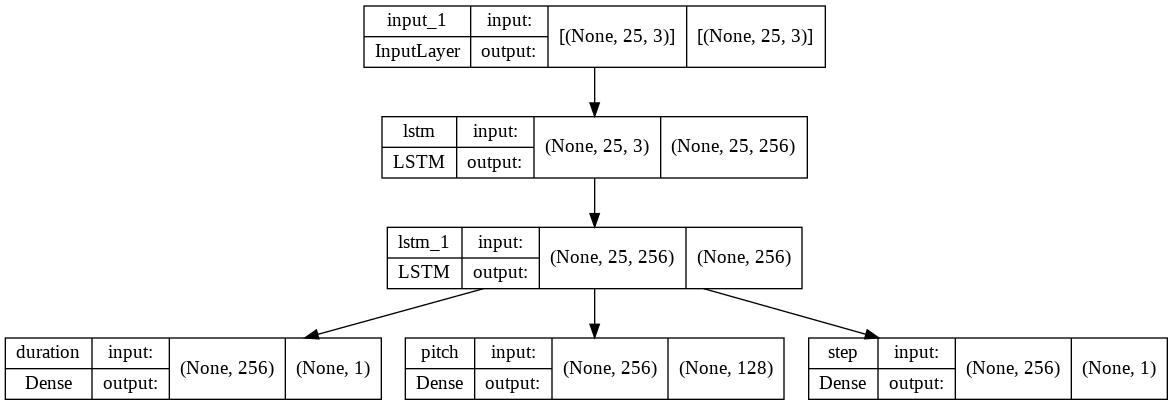

In [29]:
#Build & Compile Model
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(256, return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(256)(x)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=loss, optimizer=optimizer)
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True,expand_nested=True)

In [30]:
losses = model.evaluate(train_ds, return_dict=True)
losses

227/227 [==============================] - 11s 6ms/step - loss: 5.6976 - duration_loss: 0.3760 - pitch_loss: 4.8523 - step_loss: 0.4692


{'duration_loss': 0.37603989243507385,
 'loss': 5.697573661804199,
 'pitch_loss': 4.852339744567871,
 'step_loss': 0.46919551491737366}

In [31]:
model.compile(loss=loss, loss_weights={'pitch': 0.05, 'step': 1.0, 'duration':1.0}, optimizer=optimizer)
model.evaluate(train_ds, return_dict=True)

227/227 [==============================] - 3s 6ms/step - loss: 1.0879 - duration_loss: 0.3760 - pitch_loss: 4.8523 - step_loss: 0.4692


{'duration_loss': 0.37603989243507385,
 'loss': 1.0878523588180542,
 'pitch_loss': 4.852339744567871,
 'step_loss': 0.46919551491737366}

In [32]:
#Train Model
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./training_checkpoints/ckpt_{epoch}', save_weights_only=True), tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)]

In [33]:
%%time
epochs = 75
history = model.fit(train_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/75
227/227 [==============================] - 7s 9ms/step - loss: 0.5104 - duration_loss: 0.1345 - pitch_loss: 3.9447 - step_loss: 0.1787
Epoch 2/75
227/227 [==============================] - 2s 9ms/step - loss: 0.4599 - duration_loss: 0.1181 - pitch_loss: 3.6895 - step_loss: 0.1573
Epoch 3/75
227/227 [==============================] - 2s 9ms/step - loss: 0.4513 - duration_loss: 0.1178 - pitch_loss: 3.6337 - step_loss: 0.1518
Epoch 4/75
227/227 [==============================] - 2s 9ms/step - loss: 0.4406 - duration_loss: 0.1170 - pitch_loss: 3.5733 - step_loss: 0.1450
Epoch 5/75
227/227 [==============================] - 2s 9ms/step - loss: 0.4350 - duration_loss: 0.1168 - pitch_loss: 3.5238 - step_loss: 0.1421
Epoch 6/75
227/227 [==============================] - 2s 9ms/step - loss: 0.4283 - duration_loss: 0.1147 - pitch_loss: 3.4554 - step_loss: 0.1409
Epoch 7/75
227/227 [==============================] - 2s 9ms/step - loss: 0.4252 - duration_loss: 0.1134 - pitch_loss: 3.434

In [34]:
#Load Pre-Trained Weights
#!wget -O https://www.dropbox.com/s/zhuzqmjicbkdunv/weightsRNN.zip?dl=0
#!unzip weightsRNN.zip
#model.load_weights("weightsRNN/weights")
model.save_weights("./weightsRNN/weights")

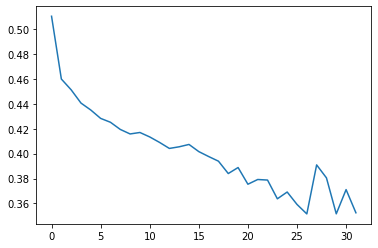

In [35]:
#Plot
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [36]:
#Generate Notes Definition
def predict_next_note(notes: np.ndarray, keras_model: tf.keras.Model, temperature: float = 1.0) -> int:
  #Generates Note ID's Using a Trained Sequence Model

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [37]:
#Generate Notes
temperature = 2.0
num_predictions = 200

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

In [38]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,74,0.925032,2.471348,0.925032,3.396380
1,84,0.317762,0.783954,1.242794,2.026748
2,84,0.400490,0.633602,1.643284,2.276886
3,73,0.300425,0.563145,1.943709,2.506855
4,77,0.320125,0.466936,2.263834,2.730770
5,90,0.333757,0.421281,2.597591,3.018872
6,86,0.371408,0.397406,2.968998,3.366404
7,86,0.368710,0.392131,3.337709,3.729840
8,79,0.370319,0.420967,3.708028,4.128995
9,90,0.390770,0.402848,4.098798,4.501646


In [39]:
out_file = 'output.mid'
out_pm = notes_to_midi(generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [40]:
#Download
from google.colab import files
#files.download(out_file)
#files.download("weightsRNN.zip")

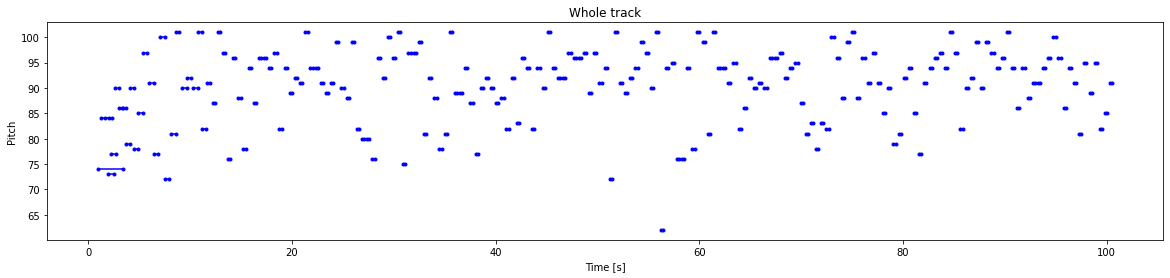

In [41]:
#Plots
plot_piano_roll(generated_notes)

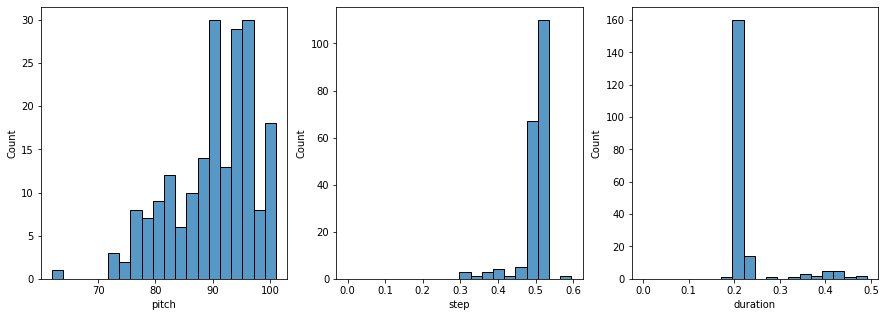

In [42]:
plot_distributions(generated_notes)